In [1]:
using Gadfly
using DataFrames

include("utils.jl")

const df_transaction = readtable("./data/transactions.csv")
const df_student     = readtable("./data/students.csv")

df_transaction[:datetime] = map(x->DateTime(x, "yyyy/mm/dd HH:MM:SS"), df_transaction[:datetime])
df_student[:count] = 1

nothing

## 总览

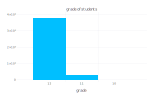

In [2]:
set_default_plot_size(6inch, 4inch)
plot(df_student, x=:grade,  Scale.x_discrete, Geom.histogram, Guide.title("grade of students"))

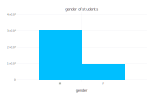

In [3]:
plot(df_student, x=:gender, Scale.x_discrete, Geom.histogram, Guide.title("gender of students"))

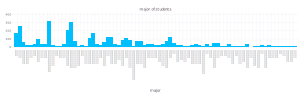

In [4]:
set_default_plot_size(12inch, 4inch)
plot(df_student, x=:major,  Scale.x_discrete, Geom.histogram, Guide.title("major of students"))

## 存款

In [5]:
df_temp = df_transaction[(df_transaction[:category].=="存款") | (df_transaction[:category].=="银行转账"),
                         [:id, :datetime, :position, :amount, :balance]]
df_temp = join(df_temp, df_student, on=:id, kind=:left)

nothing

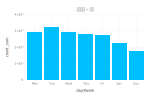

In [6]:
df_temp[:dayofweek] = map(Dates.dayofweek,  df_temp[:datetime])
set_default_plot_size(6inch, 4inch)
plot(df_temp[[:dayofweek, :count]] |> groupby(:dayofweek) |> sum,
     x=:dayofweek, y=:count_sum, Guide.xticks(ticks=collect(1:7)),
     Scale.x_continuous(labels=x->get(Dates.english_daysofweekabbr, x, "fuck")),
     Geom.bar, Guide.title("充卡次数 ~ 周几"),
     Theme(bar_spacing=2mm))

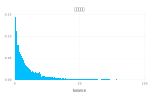

In [7]:
df_temp = df_temp[df_temp[:balance].<=100, :]
df_temp = df_temp[df_temp[:balance].>=0, :]
plot(df_temp, x=:balance, Geom.histogram(density=true), Guide.title("充卡前余额"))

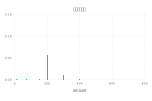

In [8]:
df_temp[df_temp[:amount].>600, :amount] = 600
plot(df_temp, x=:amount, Geom.histogram(density=true), Guide.title("单次充卡金额"))

## 消费

In [9]:
df_temp = df_transaction[df_transaction[:amount].<0, [:datetime, :amount, :id]]
df_temp[:month] = map(Dates.month, df_temp[:datetime])
df_temp[:amount] = map(abs, df_temp[:amount])
df_temp = df_temp[[:month, :id, :amount]] |> groupby([:id, :month]) |> sum

nothing

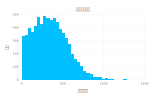

In [10]:
df_temp = df_temp[df_temp[:amount_sum].<1500, :]
plot(df_temp, x=:amount_sum, Geom.histogram(bincount=39),
     Guide.ylabel("人数"), Guide.xlabel("月均消费额"), Guide.title("月均消费额分布"))

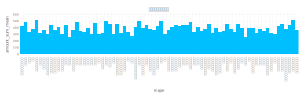

In [11]:
df_temp = df_temp[df_temp[:amount_sum].>100, :]
df_temp = join(df_temp, df_student, on=:id, kind=:left)
set_default_plot_size(12inch, 4inch)
plot(df_temp[[:amount_sum, :major]] |> groupby(:major) |> mean,
     x=:major, y=:amount_sum_mean, Geom.bar, Guide.title("各专业人均每月消费额"))

## 补助

In [12]:
df_temp = df_transaction[df_transaction[:category].=="补助", [:datetime, :amount, :id]]
df_temp = join(df_temp, df_student, on=:id, kind=:left)

nothing

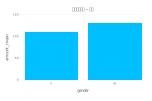

In [13]:
set_default_plot_size(6inch, 4inch)
plot(df_temp[[:gender, :amount]] |> groupby(:gender) |> mean,
     x=:gender, y=:amount_mean, Geom.bar, Theme(bar_spacing=1cm),
     Guide.title("人均补助金额 ~ 性别"))

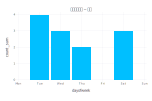

In [14]:
df_temp[:dayofweek] = map(Dates.dayofweek,  df_temp[:datetime])
plot(df_temp[[:dayofweek, :count]] |> groupby(:dayofweek) |> sum,
     x=:dayofweek, y=:count_sum, Guide.xticks(ticks=collect(1:7)),
     Scale.x_continuous(labels=x->get(Dates.english_daysofweekabbr, x, "fuck")),
     Geom.bar, Guide.title("补助发放次数 ~ 周几"),
     Theme(bar_spacing=2mm))

## 吃饭

In [15]:
restaurant = ["学苑楼商务网关", "硕果园（工大商店）", "学士楼商务网关", "学子楼商务网关", "九食堂商务网关", "四食堂商务网关", "五食堂商务网关", "土木楼网关"]
namemap = Dict("学苑楼商务网关" => "学苑", "硕果园（工大商店）" => "黑店", "学士楼商务网关" => "学士", "学子楼商务网关" => "饺子园",
               "九食堂商务网关" => "天香", "四食堂商务网关" => "清泽", "五食堂商务网关" => "锦绣", "土木楼网关" => "土木")
df_temp = df_transaction[Bool[x in restaurant for x in df_transaction[:position]], [:datetime, :amount, :position, :id]]
df_temp[:position] = map(x->namemap[x], df_temp[:position])
df_temp[:date] = map(Date, df_temp[:datetime])
divide_time(x) = begin
    x = Dates.hour(x)
    if 6 <= x <= 9
        "breakfast"
    elseif 10 <= x <= 14
        "lunch"
    elseif 16 <= x <= 20
        "dinner"
    else
        "other"
    end
end
df_temp[:time] = map(divide_time, df_temp[:datetime])
df_temp = df_temp[df_temp[:time].!="other", :]
df_temp = df_temp[[:position, :id, :date, :time, :amount]] |> groupby([:position, :id, :date, :time]) |> sum
df_temp = join(df_temp, df_student, on=:id, kind=:left)

nothing

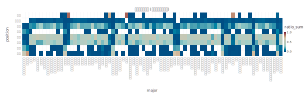

In [16]:
df_temp = join(df_temp, df_temp[[:major, :count]] |> groupby(:major) |> sum, on=:major, kind=:left)
df_temp[:ratio] = 1 ./ df_temp[:count_sum]
set_default_plot_size(12inch, 4inch)
plot(df_temp[[:major, :position, :ratio]] |> groupby([:major, :position]) |> sum,
     x=:major, y=:position, color=:ratio_sum, Geom.rectbin,
     Guide.title("各专业食堂统计 (平衡了各专业人数)"))

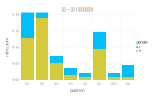

In [17]:
delete!(df_temp, :count_sum)
df_temp = join(df_temp, df_temp[[:gender, :count]] |> groupby(:gender) |> sum, on=:gender, kind=:left)
df_temp[:ratio] = 0.5 ./ df_temp[:count_sum]
set_default_plot_size(6inch, 4inch)
plot(df_temp[[:gender, :position, :ratio]] |> groupby([:gender, :position]) |> sum,
     x=:position, y=:ratio_sum, color=:gender, Geom.bar,
     Theme(bar_spacing=2mm), Guide.title("食堂 ~ 性别 (平衡了男女人数)"))

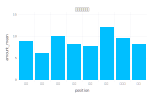

In [18]:
df_temp[:amount] = map(abs, df_temp[:amount_sum])
plot(df_temp[[:amount, :position]] |> groupby(:position) |> mean,
     x=:position, y=:amount_mean, Geom.bar, Theme(bar_spacing=2mm),
     Guide.title("各食堂平均消费"))

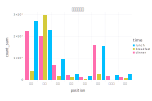

In [19]:
plot(df_temp[[:count, :position, :time]] |> groupby([:position, :time]) |> sum,
     x=:position, y=:count_sum, color=:time, Geom.bar(position=:dodge),
     Theme(bar_spacing=2mm), Guide.title("各餐食堂分布"))

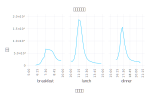

In [20]:
df_temp = df_transaction[[:datetime, :id]]
df_temp[:count] = 1
df_temp[:time] = map(divide_time, df_temp[:datetime])
df_temp[:date] = map(Date, df_temp[:datetime])
df_temp = df_temp[df_temp[:time].!="other", :]
df_temp[:tp] = map(df_temp[:datetime]) do x Dates.hour(x) * 4 + div(Dates.minute(x), 15) end
df_temp = df_temp[[:date, :time, :id, :tp, :count]] |> groupby([:date, :time, :id]) |> minimum
plot(df_temp[[:tp_minimum, :time, :count_minimum]] |> groupby([:tp_minimum, :time]) |> sum |> sortby(:tp_minimum),
     x=:tp_minimum, y=:count_minimum_sum, xgroup=:time, Geom.subplot_grid(Geom.line, free_x_axis=true),
     Scale.x_continuous(labels=x->@sprintf("%d:%02d", div(x, 4), 15 * rem(x, 4))),
     Guide.xlabel("就餐时间"), Guide.ylabel("次数"), Guide.title("就餐时段分布"))

## 健身

In [21]:
gym = ["体育部健身俱乐部", "游泳馆", "体育场B", "一区羽毛球馆", "小足球场A"]
df_temp = df_transaction[Bool[x in gym for x in df_transaction[:position]], [:datetime, :amount, :id]]
df_temp = join(df_temp, df_student, on=:id, kind=:left)

nothing

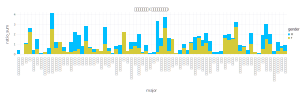

In [22]:
df_temp = join(df_temp, df_student[[:major, :gender, :count]] |> groupby([:major, :gender]) |> sum,
               on=[:major, :gender], kind=:left)
df_temp[:ratio] = 1 ./ df_temp[:count_sum]
set_default_plot_size(12inch, 4inch)
plot(df_temp[[:major, :gender, :ratio]] |> groupby([:major, :gender]) |> sum,
     x=:major, y=:ratio_sum, color=:gender, Geom.bar,
     Guide.title("各专业健身比例 (已平衡各专业性别)"))

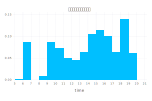

In [23]:
df_temp[:time] = map(Dates.hour, df_temp[:datetime])
set_default_plot_size(6inch, 4inch)
plot(df_temp, x=:time, Guide.xticks(ticks=collect(5:21)),
     Geom.histogram(density=true), Guide.title("一天中不同时段锻炼次数"))

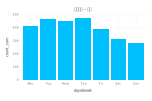

In [24]:
df_temp[:dayofweek] = map(Dates.dayofweek,  df_temp[:datetime])
plot(df_temp[[:dayofweek, :count]] |> groupby(:dayofweek) |> sum,
     x=:dayofweek, y=:count_sum, Guide.xticks(ticks=collect(1:7)),
     Scale.x_continuous(labels=x->get(Dates.english_daysofweekabbr, x, "fuck")),
     Geom.bar, Guide.title("锻炼次数 ~ 周几"),
     Theme(bar_spacing=2mm))

## 洗澡

In [25]:
bath = ["一校区水控新", "二区水控", "15公寓浴池", "土木楼水控"]
price = 0.3 # 每分钟热水价格
df_temp = df_transaction[Bool[x in bath for x in df_transaction[:position]], [:datetime, :amount, :id]]

starttime(x) = minimum(x) |> Dates.hour
duration(x) = (maximum(x) - minimum(x)).value / 60_000
lasttime(x) = x[end]

df_temp[:date] = map(Date, df_temp[:datetime])
df_temp = join(df_temp[[:id, :date, :datetime]] |> groupby([:id, :date]) |> [starttime, duration],
               df_temp[[:id, :date, :amount]] |> groupby([:id, :date]) |> lasttime,
               on=[:id, :date], kind=:inner)
df_temp[:datetime_duration] += -df_temp[:amount_lasttime] ./ price
df_temp = join(df_temp, df_student, on=:id, kind=:left)

nothing

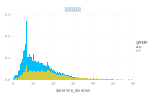

In [26]:
df_temp = df_temp[df_temp[:datetime_duration].<60, :]
plot(df_temp, x=:datetime_duration, color=:gender, Geom.histogram(density=true),
     Guide.title("人均每次洗澡时间"))

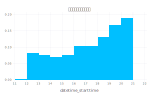

In [27]:
df_temp = df_temp[df_temp[:datetime_starttime].>10, :]
plot(df_temp, x=:datetime_starttime, Geom.histogram(density=true),
     Guide.xticks(ticks=collect(11:22)), Guide.title("一天中不同时段洗澡比率"))

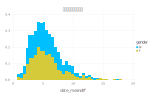

In [28]:
meandiff(x) = [x.value for x in [x...;x[end]]-[x[1];x...]] |> mean
df_temp = df_temp[[:date, :id]] |> groupby(:id) |> meandiff
df_temp = df_temp[df_temp[:date_meandiff] .> .5, :]
plot(join(df_temp, df_student, on=:id, kind=:left), x=:date_meandiff, color=:gender,
     Geom.histogram(density=true, bincount=39), Guide.title("平均两次洗澡间隔天数"))

## 超市

In [29]:
shop = ["学子便利店A01后楼", "学子便利店B07", "学子便利店B03", "学子便利店B05", "学子超市A05", "南苑超市A17", "学子便利店B06", "学子便利店B02", "学子便利店B04", "十三公寓便利店", "超市A04"]
mall = ["超市商务子系统", "学子超市园丁总店", "学子便利海河店", "学子超市园丁分店"]

df_temp = df_transaction[Bool[x in [shop; mall] for x in df_transaction[:position]], [:datetime, :amount, :id, :position]]
df_temp[:position] = map(df_temp[:position]) do x x in mall ? "mall" : "shop" end
df_temp[:amount] = map(abs, df_temp[:amount])

nothing

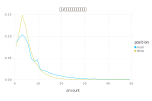

In [30]:
df_temp = df_temp[df_temp[:amount] .<50, :]
plot(df_temp, x=:amount, color=:position, Stat.histogram(bincount=39, density=true), Geom.line,
     Scale.y_continuous(minvalue=0, maxvalue=0.15), Guide.title("超市/公寓便利店单次消费分布"))

## 网络

In [31]:
df_temp = df_transaction[df_transaction[:position].=="网络中心", [:amount]]

nothing

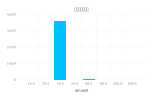

In [32]:
df_temp[:amount] = map(abs, df_temp[:amount])
plot(df_temp |> sortby(:amount), x=:amount, Geom.histogram,
      Scale.x_discrete, Theme(bar_spacing=2mm), Guide.title("单次交网费金额"))

## 洗衣币

In [33]:
dormitory = ["A15", "B7", "A1", "A2", "B3", "A7", "A18", "A5", "A9", "B6", "A16", "B4", "A6", "A12"]
df_temp = df_transaction[Bool[x in dormitory for x in df_transaction[:position]], [:amount]]

nothing

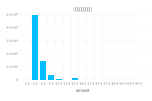

In [34]:
df_temp[:amount] = map(abs, df_temp[:amount])
df_temp = df_temp[(df_temp[:amount].>=1) & (df_temp[:amount].<=100), :]
plot(df_temp |> sortby(:amount), x=:amount, Geom.histogram,
      Scale.x_discrete, Theme(bar_spacing=2mm), Guide.title("单次购买洗衣币金额"))